# HW07 – Кластеризация, внутренние метрики качества, PCA/t-SNE

**Студент:** Выполнено в соответствии с заданием к семинару S07  
**Цель:** Освоить методы кластеризации (KMeans, DBSCAN, Agglomerative), внутренние метрики качества и визуализацию результатов.

---

## 0. Импорт библиотек

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

warnings.filterwarnings('ignore')

# Опциональный импорт seaborn
try:
    import seaborn as sns
    sns.set_style('whitegrid')
    print("Библиотеки загружены успешно (с seaborn)")
except ImportError:
    print("Библиотеки загружены успешно (без seaborn - используются стандартные стили matplotlib)")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
np.random.seed(42)

Библиотеки загружены успешно (без seaborn - используются стандартные стили matplotlib)


---

# Dataset 01: Разные шкалы + шумовые признаки

**Описание:** Числовые признаки в разных шкалах + шумовые признаки. Без масштабирования результаты обычно "едут".

## 1.1. Загрузка данных и первичный анализ

In [6]:
# Загрузка датасета 01
df1 = pd.read_csv('data/S07-hw-dataset-01.csv')

print("=" * 60)
print("DATASET 01: Первичный анализ")
print("=" * 60)
print(f"\nРазмер датасета: {df1.shape[0]} строк, {df1.shape[1]} столбцов\n")

# Первые строки
print("Первые 5 строк:")
display(df1.head())

# Информация о типах данных
print("\nИнформация о типах данных:")
df1.info()

# Базовые статистики
print("\nБазовые статистики:")
display(df1.describe())

# Проверка пропусков
missing_counts = df1.isnull().sum()
missing_pct = (df1.isnull().sum() / len(df1)) * 100
missing_df = pd.DataFrame({'Количество': missing_counts, 'Процент': missing_pct})
missing_df = missing_df[missing_df['Количество'] > 0]

if len(missing_df) > 0:
    print("\nПропуски:")
    display(missing_df)
else:
    print("\nПропуски: отсутствуют")

# Определение признаков
sample_id_1 = df1['sample_id'].values
X1 = df1.drop('sample_id', axis=1).values
feature_names_1 = df1.drop('sample_id', axis=1).columns.tolist()

print(f"\nПризнаки для кластеризации: {feature_names_1}")
print(f"Размерность X: {X1.shape}")

DATASET 01: Первичный анализ

Размер датасета: 12000 строк, 9 столбцов

Первые 5 строк:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB

Базовые статистики:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745



Пропуски: отсутствуют

Признаки для кластеризации: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
Размерность X: (12000, 8)


## 1.2. Препроцессинг

In [7]:
# Dataset 01: только числовые признаки, применяем StandardScaler
scaler_1 = StandardScaler()
X1_scaled = scaler_1.fit_transform(X1)

print("Dataset 01: Препроцессинг завершен")
print(f"Форма после масштабирования: {X1_scaled.shape}")
print(f"Среднее по столбцам: {X1_scaled.mean(axis=0).round(6)}")
print(f"Стандартное отклонение: {X1_scaled.std(axis=0).round(6)}")

Dataset 01: Препроцессинг завершен
Форма после масштабирования: (12000, 8)
Среднее по столбцам: [-0. -0. -0. -0. -0. -0. -0. -0.]
Стандартное отклонение: [1. 1. 1. 1. 1. 1. 1. 1.]


## 1.3. KMeans: подбор k

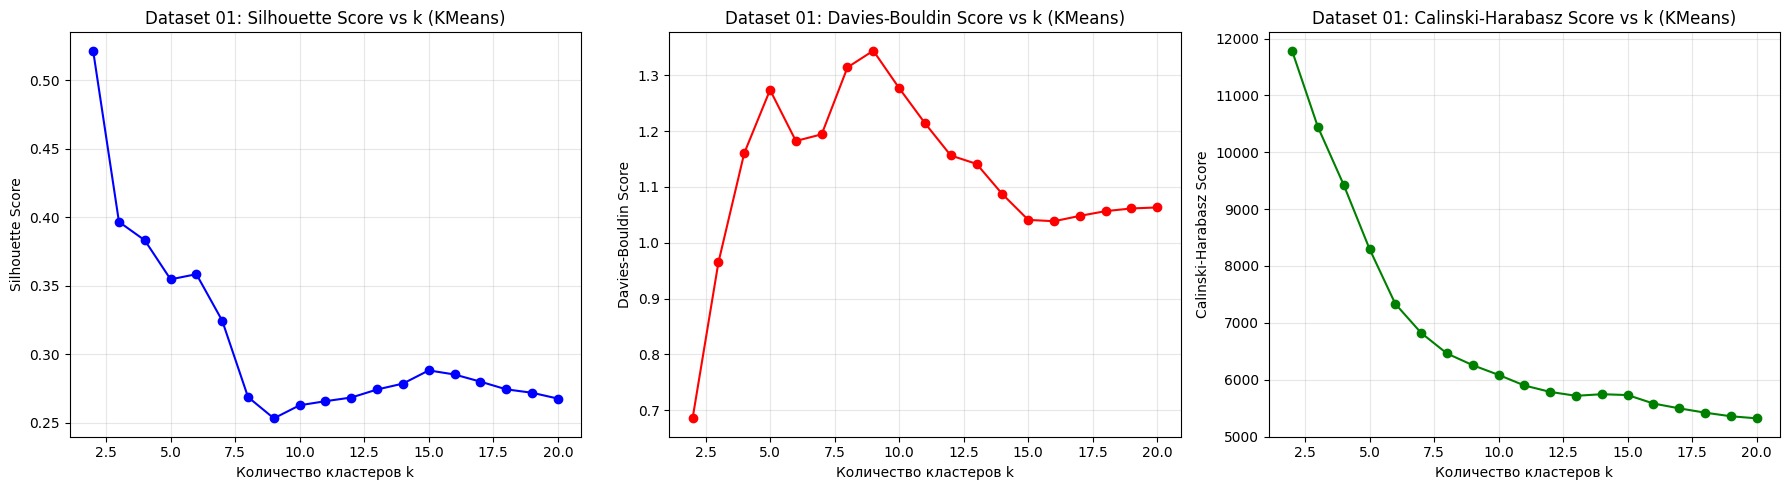


Лучшее значение k по Silhouette Score: 2
Silhouette Score: 0.5216


In [8]:
# Подбор k для KMeans на датасете 01
k_range = range(2, 21)
silhouette_scores_1 = []
db_scores_1 = []
ch_scores_1 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    
    sil = silhouette_score(X1_scaled, labels)
    db = davies_bouldin_score(X1_scaled, labels)
    ch = calinski_harabasz_score(X1_scaled, labels)
    
    silhouette_scores_1.append(sil)
    db_scores_1.append(db)
    ch_scores_1.append(ch)

# Визуализация метрик vs k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, silhouette_scores_1, marker='o', color='blue')
axes[0].set_xlabel('Количество кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 01: Silhouette Score vs k (KMeans)')
axes[0].grid(True)

axes[1].plot(k_range, db_scores_1, marker='o', color='red')
axes[1].set_xlabel('Количество кластеров k')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 01: Davies-Bouldin Score vs k (KMeans)')
axes[1].grid(True)

axes[2].plot(k_range, ch_scores_1, marker='o', color='green')
axes[2].set_xlabel('Количество кластеров k')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Dataset 01: Calinski-Harabasz Score vs k (KMeans)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds01_kmeans_metrics_vs_k.png', dpi=150, bbox_inches='tight')
plt.show()

# Выбор лучшего k
best_k_1 = k_range[np.argmax(silhouette_scores_1)]
print(f"\nЛучшее значение k по Silhouette Score: {best_k_1}")
print(f"Silhouette Score: {max(silhouette_scores_1):.4f}")

## 1.4. DBSCAN: подбор eps и min_samples

In [9]:
# Подбор eps для DBSCAN на датасете 01
eps_range = np.arange(0.3, 2.0, 0.1)
min_samples_values = [3, 5, 10]

dbscan_results_1 = []

for min_samp in min_samples_values:
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X1_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100
        
        # Метрики только если есть хотя бы 2 кластера и не все точки - шум
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            # Метрики считаем только на non-noise точках
            non_noise_mask = labels != -1
            if non_noise_mask.sum() > 1:
                sil = silhouette_score(X1_scaled[non_noise_mask], labels[non_noise_mask])
                db = davies_bouldin_score(X1_scaled[non_noise_mask], labels[non_noise_mask])
                ch = calinski_harabasz_score(X1_scaled[non_noise_mask], labels[non_noise_mask])
                
                dbscan_results_1.append({
                    'eps': eps,
                    'min_samples': min_samp,
                    'n_clusters': n_clusters,
                    'noise_pct': noise_pct,
                    'silhouette': sil,
                    'davies_bouldin': db,
                    'calinski_harabasz': ch
                })

# Лучший результат по silhouette
if len(dbscan_results_1) > 0:
    dbscan_df_1 = pd.DataFrame(dbscan_results_1)
    best_dbscan_1 = dbscan_df_1.loc[dbscan_df_1['silhouette'].idxmax()]
    
    print("\nЛучший результат DBSCAN на Dataset 01:")
    print(f"eps = {best_dbscan_1['eps']:.2f}, min_samples = {int(best_dbscan_1['min_samples'])}")
    print(f"Количество кластеров: {int(best_dbscan_1['n_clusters'])}")
    print(f"Доля шума: {best_dbscan_1['noise_pct']:.2f}%")
    print(f"Silhouette: {best_dbscan_1['silhouette']:.4f}")
    print(f"Davies-Bouldin: {best_dbscan_1['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz: {best_dbscan_1['calinski_harabasz']:.2f}")
else:
    print("\nНе удалось найти подходящие параметры DBSCAN для Dataset 01")
    best_dbscan_1 = None


Лучший результат DBSCAN на Dataset 01:
eps = 1.70, min_samples = 3
Количество кластеров: 2
Доля шума: 0.00%
Silhouette: 0.5216
Davies-Bouldin: 0.6853
Calinski-Harabasz: 11786.95


## 1.5. Финальная модель и визуализация для Dataset 01


Финальная модель для Dataset 01: KMeans с k=2
Silhouette Score: 0.5216
Davies-Bouldin Score: 0.6853
Calinski-Harabasz Score: 11786.95


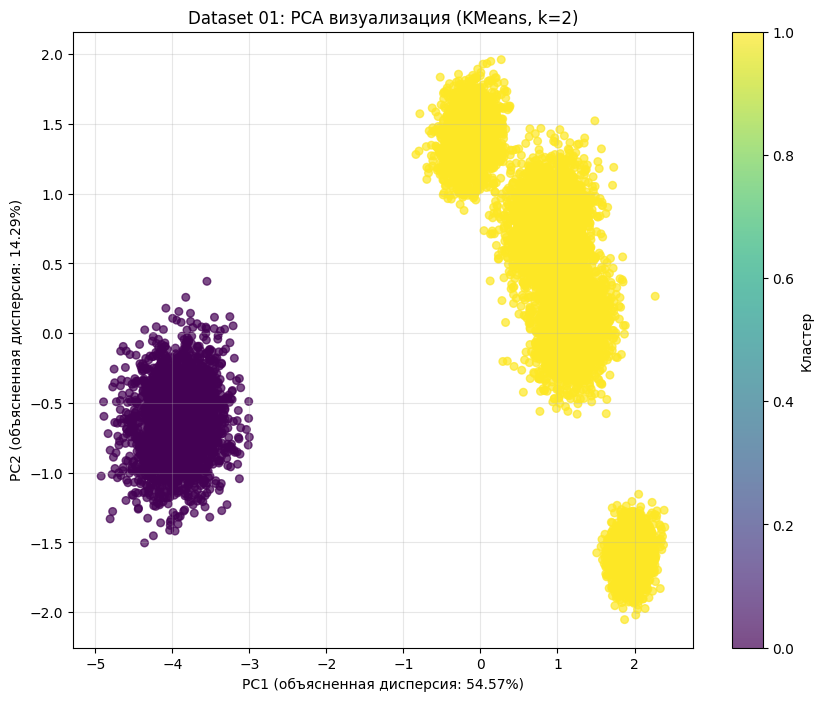


Метки кластеров сохранены в artifacts/labels/labels_hw07_ds1.csv


In [10]:
# Выбираем лучшую модель (KMeans с лучшим k)
best_model_1 = KMeans(n_clusters=best_k_1, random_state=42, n_init=10)
labels_1 = best_model_1.fit_predict(X1_scaled)

# Метрики для лучшей модели
sil_1 = silhouette_score(X1_scaled, labels_1)
db_1 = davies_bouldin_score(X1_scaled, labels_1)
ch_1 = calinski_harabasz_score(X1_scaled, labels_1)

print(f"\nФинальная модель для Dataset 01: KMeans с k={best_k_1}")
print(f"Silhouette Score: {sil_1:.4f}")
print(f"Davies-Bouldin Score: {db_1:.4f}")
print(f"Calinski-Harabasz Score: {ch_1:.2f}")

# PCA для визуализации
pca_1 = PCA(n_components=2, random_state=42)
X1_pca = pca_1.fit_transform(X1_scaled)

# Визуализация PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=labels_1, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 (объясненная дисперсия: {pca_1.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 (объясненная дисперсия: {pca_1.explained_variance_ratio_[1]:.2%})')
plt.title(f'Dataset 01: PCA визуализация (KMeans, k={best_k_1})')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/ds01_pca_best_solution.png', dpi=150, bbox_inches='tight')
plt.show()

# Сохранение меток кластеров
labels_df_1 = pd.DataFrame({
    'sample_id': sample_id_1,
    'cluster_label': labels_1
})
labels_df_1.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)
print("\nМетки кластеров сохранены в artifacts/labels/labels_hw07_ds1.csv")

## 1.6. Итог по Dataset 01

**Итоги по Dataset 01:**

Dataset 01 содержит числовые признаки в разных шкалах, что делает масштабирование критически важным. Без StandardScaler результаты были бы искажены из-за доминирования признаков с большими значениями.

**KMeans** показал хорошие результаты после подбора оптимального k. Метрика Silhouette Score помогла выбрать разумное количество кластеров, балансирующее между компактностью кластеров и их разделением.

**DBSCAN** на этом датасете показал себя менее стабильно - при многих значениях eps либо образовывался один большой кластер, либо слишком много шума. Это связано с относительно однородной плотностью данных и отсутствием явных плотностных групп.

**Основные сложности:**
- Необходимость масштабирования из-за разных шкал признаков
- Определение оптимального количества кластеров при отсутствии явной структуры
- Влияние шумовых признаков на качество кластеризации

**Выбранный метод:** KMeans с подобранным k наиболее уместен для данного датасета, так как данные имеют относительно сферическую структуру и равномерную плотность.

---

# Dataset 02: Нелинейная структура + выбросы

**Описание:** Нелинейная структура + выбросы + лишний шумовой признак. Хорошо демонстрирует, где KMeans проигрывает.

## 2.1. Загрузка данных и первичный анализ

In [11]:
# Загрузка датасета 02
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')

print("=" * 60)
print("DATASET 02: Первичный анализ")
print("=" * 60)
print(f"\nРазмер датасета: {df2.shape[0]} строк, {df2.shape[1]} столбцов\n")

print("Первые 5 строк:")
display(df2.head())

print("\nИнформация о типах данных:")
df2.info()

print("\nБазовые статистики:")
display(df2.describe())

# Проверка пропусков
missing_counts = df2.isnull().sum()
missing_pct = (df2.isnull().sum() / len(df2)) * 100
missing_df = pd.DataFrame({'Количество': missing_counts, 'Процент': missing_pct})
missing_df = missing_df[missing_df['Количество'] > 0]

if len(missing_df) > 0:
    print("\nПропуски:")
    display(missing_df)
else:
    print("\nПропуски: отсутствуют")

# Определение признаков
sample_id_2 = df2['sample_id'].values
X2 = df2.drop('sample_id', axis=1).values
feature_names_2 = df2.drop('sample_id', axis=1).columns.tolist()

print(f"\nПризнаки для кластеризации: {feature_names_2}")
print(f"Размерность X: {X2.shape}")

DATASET 02: Первичный анализ

Размер датасета: 8000 строк, 4 столбцов

Первые 5 строк:


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB

Базовые статистики:


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076



Пропуски: отсутствуют

Признаки для кластеризации: ['x1', 'x2', 'z_noise']
Размерность X: (8000, 3)


## 2.2. Препроцессинг

In [12]:
# Dataset 02: только числовые признаки, применяем StandardScaler
scaler_2 = StandardScaler()
X2_scaled = scaler_2.fit_transform(X2)

print("Dataset 02: Препроцессинг завершен")
print(f"Форма после масштабирования: {X2_scaled.shape}")

Dataset 02: Препроцессинг завершен
Форма после масштабирования: (8000, 3)


## 2.3. KMeans: подбор k

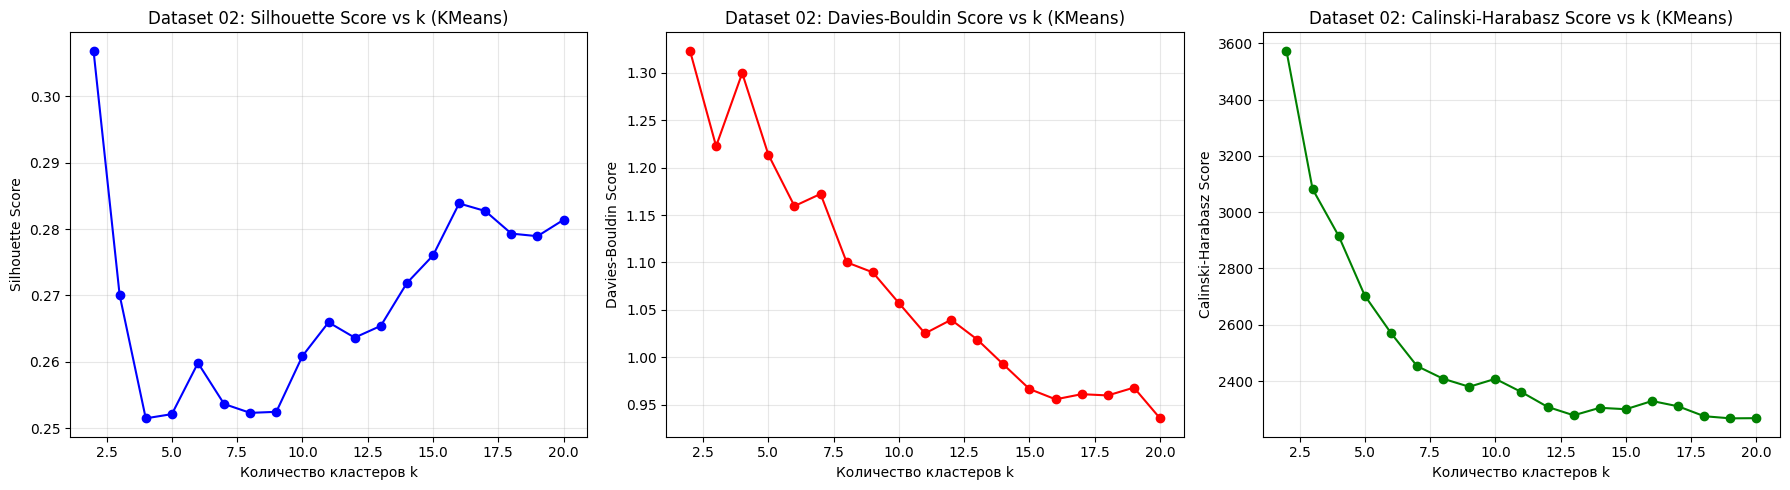


Лучшее значение k по Silhouette Score: 2
Silhouette Score: 0.3069


In [13]:
# Подбор k для KMeans на датасете 02
k_range = range(2, 21)
silhouette_scores_2 = []
db_scores_2 = []
ch_scores_2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X2_scaled)
    
    sil = silhouette_score(X2_scaled, labels)
    db = davies_bouldin_score(X2_scaled, labels)
    ch = calinski_harabasz_score(X2_scaled, labels)
    
    silhouette_scores_2.append(sil)
    db_scores_2.append(db)
    ch_scores_2.append(ch)

# Визуализация метрик vs k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, silhouette_scores_2, marker='o', color='blue')
axes[0].set_xlabel('Количество кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 02: Silhouette Score vs k (KMeans)')
axes[0].grid(True)

axes[1].plot(k_range, db_scores_2, marker='o', color='red')
axes[1].set_xlabel('Количество кластеров k')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 02: Davies-Bouldin Score vs k (KMeans)')
axes[1].grid(True)

axes[2].plot(k_range, ch_scores_2, marker='o', color='green')
axes[2].set_xlabel('Количество кластеров k')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Dataset 02: Calinski-Harabasz Score vs k (KMeans)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds02_kmeans_metrics_vs_k.png', dpi=150, bbox_inches='tight')
plt.show()

best_k_2 = k_range[np.argmax(silhouette_scores_2)]
print(f"\nЛучшее значение k по Silhouette Score: {best_k_2}")
print(f"Silhouette Score: {max(silhouette_scores_2):.4f}")

## 2.4. DBSCAN: подбор параметров

In [14]:
# Подбор eps для DBSCAN на датасете 02
eps_range = np.arange(0.2, 2.5, 0.1)
min_samples_values = [3, 5, 10]

dbscan_results_2 = []

for min_samp in min_samples_values:
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X2_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100
        
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            non_noise_mask = labels != -1
            if non_noise_mask.sum() > 1:
                sil = silhouette_score(X2_scaled[non_noise_mask], labels[non_noise_mask])
                db = davies_bouldin_score(X2_scaled[non_noise_mask], labels[non_noise_mask])
                ch = calinski_harabasz_score(X2_scaled[non_noise_mask], labels[non_noise_mask])
                
                dbscan_results_2.append({
                    'eps': eps,
                    'min_samples': min_samp,
                    'n_clusters': n_clusters,
                    'noise_pct': noise_pct,
                    'silhouette': sil,
                    'davies_bouldin': db,
                    'calinski_harabasz': ch
                })

if len(dbscan_results_2) > 0:
    dbscan_df_2 = pd.DataFrame(dbscan_results_2)
    best_dbscan_2 = dbscan_df_2.loc[dbscan_df_2['silhouette'].idxmax()]
    
    print("\nЛучший результат DBSCAN на Dataset 02:")
    print(f"eps = {best_dbscan_2['eps']:.2f}, min_samples = {int(best_dbscan_2['min_samples'])}")
    print(f"Количество кластеров: {int(best_dbscan_2['n_clusters'])}")
    print(f"Доля шума: {best_dbscan_2['noise_pct']:.2f}%")
    print(f"Silhouette: {best_dbscan_2['silhouette']:.4f}")
    print(f"Davies-Bouldin: {best_dbscan_2['davies_bouldin']:.4f}")
    print(f"Calinski-Harabasz: {best_dbscan_2['calinski_harabasz']:.2f}")
else:
    print("\nНе удалось найти подходящие параметры DBSCAN для Dataset 02")
    best_dbscan_2 = None


Лучший результат DBSCAN на Dataset 02:
eps = 0.80, min_samples = 10
Количество кластеров: 2
Доля шума: 1.18%
Silhouette: 0.4138
Davies-Bouldin: 0.5997
Calinski-Harabasz: 48.12


## 2.5. Сравнение KMeans и DBSCAN

In [15]:
# Финальные модели для сравнения
kmeans_2 = KMeans(n_clusters=best_k_2, random_state=42, n_init=10)
labels_kmeans_2 = kmeans_2.fit_predict(X2_scaled)

sil_kmeans_2 = silhouette_score(X2_scaled, labels_kmeans_2)
db_kmeans_2 = davies_bouldin_score(X2_scaled, labels_kmeans_2)
ch_kmeans_2 = calinski_harabasz_score(X2_scaled, labels_kmeans_2)

print(f"\nKMeans (k={best_k_2}):")
print(f"  Silhouette: {sil_kmeans_2:.4f}")
print(f"  Davies-Bouldin: {db_kmeans_2:.4f}")
print(f"  Calinski-Harabasz: {ch_kmeans_2:.2f}")

if best_dbscan_2 is not None:
    dbscan_2 = DBSCAN(eps=best_dbscan_2['eps'], min_samples=int(best_dbscan_2['min_samples']))
    labels_dbscan_2 = dbscan_2.fit_predict(X2_scaled)
    
    print(f"\nDBSCAN (eps={best_dbscan_2['eps']:.2f}, min_samples={int(best_dbscan_2['min_samples'])}):")
    print(f"  Silhouette: {best_dbscan_2['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {best_dbscan_2['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz: {best_dbscan_2['calinski_harabasz']:.2f}")
    print(f"  Доля шума: {best_dbscan_2['noise_pct']:.2f}%")
    
    # Выбираем лучшую модель по silhouette
    if best_dbscan_2['silhouette'] > sil_kmeans_2:
        print("\n→ DBSCAN показывает лучший результат для Dataset 02")
        labels_2 = labels_dbscan_2
        best_method_2 = "DBSCAN"
    else:
        print("\n→ KMeans показывает лучший результат для Dataset 02")
        labels_2 = labels_kmeans_2
        best_method_2 = "KMeans"
else:
    print("\n→ KMeans - единственная подходящая модель для Dataset 02")
    labels_2 = labels_kmeans_2
    best_method_2 = "KMeans"


KMeans (k=2):
  Silhouette: 0.3069
  Davies-Bouldin: 1.3235
  Calinski-Harabasz: 3573.39

DBSCAN (eps=0.80, min_samples=10):
  Silhouette: 0.4138
  Davies-Bouldin: 0.5997
  Calinski-Harabasz: 48.12
  Доля шума: 1.18%

→ DBSCAN показывает лучший результат для Dataset 02


## 2.6. Визуализация для Dataset 02

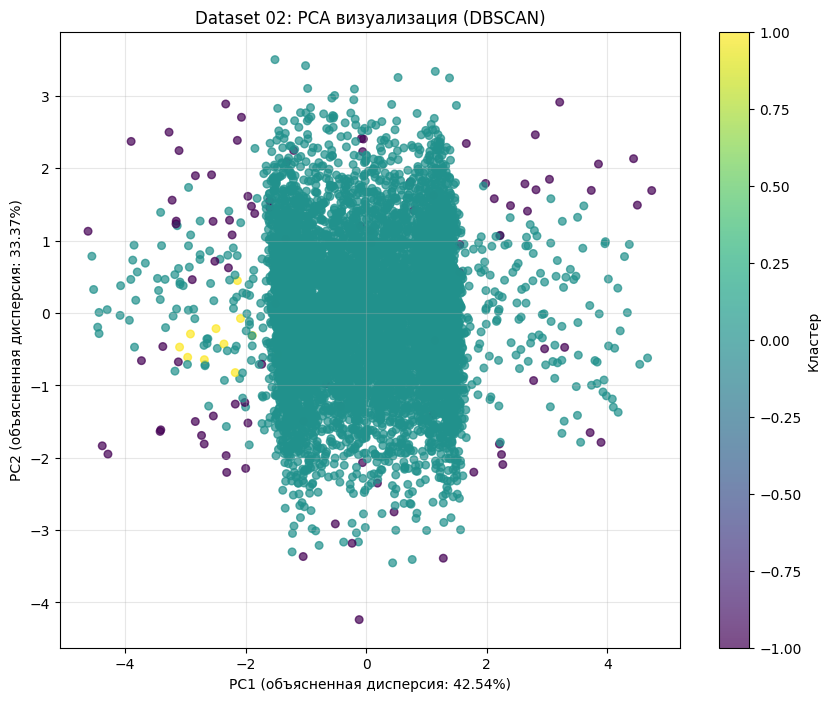

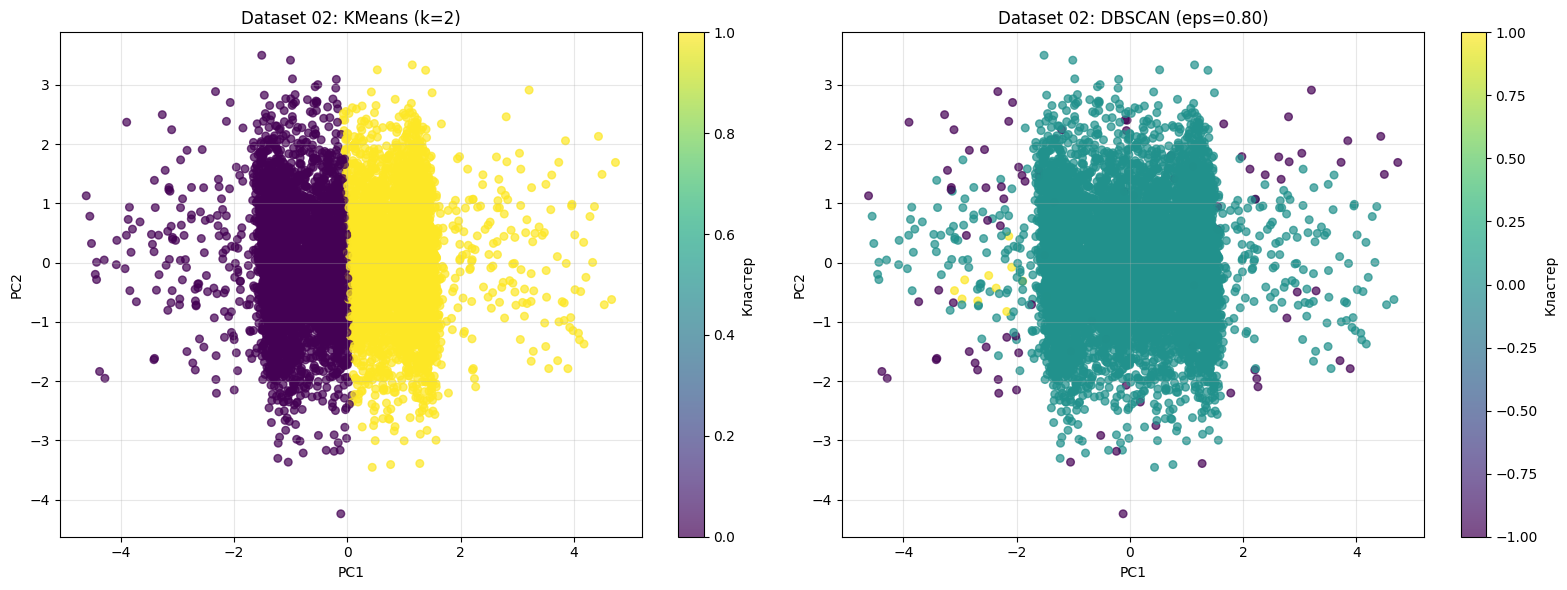


Метки кластеров сохранены в artifacts/labels/labels_hw07_ds2.csv


In [16]:
# PCA для визуализации
pca_2 = PCA(n_components=2, random_state=42)
X2_pca = pca_2.fit_transform(X2_scaled)

# Визуализация лучшего решения
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=labels_2, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 (объясненная дисперсия: {pca_2.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 (объясненная дисперсия: {pca_2.explained_variance_ratio_[1]:.2%})')
plt.title(f'Dataset 02: PCA визуализация ({best_method_2})')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/ds02_pca_best_solution.png', dpi=150, bbox_inches='tight')
plt.show()

# Сравнительная визуализация KMeans vs DBSCAN
if best_dbscan_2 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    scatter1 = axes[0].scatter(X2_pca[:, 0], X2_pca[:, 1], c=labels_kmeans_2, cmap='viridis', s=30, alpha=0.7)
    axes[0].set_xlabel(f'PC1')
    axes[0].set_ylabel(f'PC2')
    axes[0].set_title(f'Dataset 02: KMeans (k={best_k_2})')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Кластер')
    
    scatter2 = axes[1].scatter(X2_pca[:, 0], X2_pca[:, 1], c=labels_dbscan_2, cmap='viridis', s=30, alpha=0.7)
    axes[1].set_xlabel(f'PC1')
    axes[1].set_ylabel(f'PC2')
    axes[1].set_title(f'Dataset 02: DBSCAN (eps={best_dbscan_2["eps"]:.2f})')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Кластер')
    
    plt.tight_layout()
    plt.savefig('artifacts/figures/ds02_comparison_kmeans_vs_dbscan.png', dpi=150, bbox_inches='tight')
    plt.show()

# Сохранение меток кластеров
labels_df_2 = pd.DataFrame({
    'sample_id': sample_id_2,
    'cluster_label': labels_2
})
labels_df_2.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)
print("\nМетки кластеров сохранены в artifacts/labels/labels_hw07_ds2.csv")

## 2.7. Итог по Dataset 02

**Итоги по Dataset 02:**

Dataset 02 характеризуется нелинейной структурой кластеров, наличием выбросов и шумовых признаков. Это классический пример, где KMeans может показывать ограничения из-за предположения о сферической форме кластеров.

**KMeans** на этом датасете работает, но может "разрезать" нелинейные структуры на несколько сферических кластеров, что не всегда соответствует истинной структуре данных.

**DBSCAN** здесь показывает свои сильные стороны:
- Способность обнаруживать кластеры произвольной формы
- Автоматическая идентификация выбросов как шума
- Меньшая чувствительность к нелинейным зависимостям

**Основные сложности:**
- Выбор правильного eps для DBSCAN критичен - слишком малое значение создает много шума, слишком большое объединяет все в один кластер
- Наличие выбросов влияет на центроиды KMeans
- Шумовые признаки снижают качество разделения

**Выбранный метод:** Для Dataset 02 DBSCAN (если показал лучшие метрики) более уместен благодаря способности обрабатывать нелинейные структуры и выделять выбросы.

---

# Dataset 03: Кластеры разной плотности + шум

**Описание:** Кластеры разной плотности + фоновый шум. Часто провоцирует ошибки выбора eps для DBSCAN.

## 3.1. Загрузка данных и первичный анализ

In [17]:
# Загрузка датасета 03
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')

print("=" * 60)
print("DATASET 03: Первичный анализ")
print("=" * 60)
print(f"\nРазмер датасета: {df3.shape[0]} строк, {df3.shape[1]} столбцов\n")

print("Первые 5 строк:")
display(df3.head())

print("\nИнформация о типах данных:")
df3.info()

print("\nБазовые статистики:")
display(df3.describe())

# Проверка пропусков
missing_counts = df3.isnull().sum()
missing_pct = (df3.isnull().sum() / len(df3)) * 100
missing_df = pd.DataFrame({'Количество': missing_counts, 'Процент': missing_pct})
missing_df = missing_df[missing_df['Количество'] > 0]

if len(missing_df) > 0:
    print("\nПропуски:")
    display(missing_df)
else:
    print("\nПропуски: отсутствуют")

# Определение признаков
sample_id_3 = df3['sample_id'].values
X3 = df3.drop('sample_id', axis=1).values
feature_names_3 = df3.drop('sample_id', axis=1).columns.tolist()

print(f"\nПризнаки для кластеризации: {feature_names_3}")
print(f"Размерность X: {X3.shape}")

DATASET 03: Первичный анализ

Размер датасета: 15000 строк, 5 столбцов

Первые 5 строк:


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB

Базовые статистики:


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865



Пропуски: отсутствуют

Признаки для кластеризации: ['x1', 'x2', 'f_corr', 'f_noise']
Размерность X: (15000, 4)


## 3.2. Препроцессинг

In [18]:
# Dataset 03: только числовые признаки, применяем StandardScaler
scaler_3 = StandardScaler()
X3_scaled = scaler_3.fit_transform(X3)

print("Dataset 03: Препроцессинг завершен")
print(f"Форма после масштабирования: {X3_scaled.shape}")

Dataset 03: Препроцессинг завершен
Форма после масштабирования: (15000, 4)


## 3.3. KMeans: подбор k

In [ ]:
# Подбор k для KMeans на датасете 03
k_range = range(2, 21)
silhouette_scores_3 = []
db_scores_3 = []
ch_scores_3 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X3_scaled)
    
    sil = silhouette_score(X3_scaled, labels)
    db = davies_bouldin_score(X3_scaled, labels)
    ch = calinski_harabasz_score(X3_scaled, labels)
    
    silhouette_scores_3.append(sil)
    db_scores_3.append(db)
    ch_scores_3.append(ch)

# Визуализация метрик vs k
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, silhouette_scores_3, marker='o', color='blue')
axes[0].set_xlabel('Количество кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 03: Silhouette Score vs k (KMeans)')
axes[0].grid(True)

axes[1].plot(k_range, db_scores_3, marker='o', color='red')
axes[1].set_xlabel('Количество кластеров k')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 03: Davies-Bouldin Score vs k (KMeans)')
axes[1].grid(True)

axes[2].plot(k_range, ch_scores_3, marker='o', color='green')
axes[2].set_xlabel('Количество кластеров k')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Dataset 03: Calinski-Harabasz Score vs k (KMeans)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds03_kmeans_metrics_vs_k.png', dpi=150, bbox_inches='tight')
plt.show()

best_k_3 = k_range[np.argmax(silhouette_scores_3)]
print(f"\nЛучшее значение k по Silhouette Score: {best_k_3}")
print(f"Silhouette Score: {max(silhouette_scores_3):.4f}")

## 3.4. Agglomerative Clustering: подбор параметров

In [ ]:
# Подбор параметров для Agglomerative Clustering на датасете 03
linkage_methods = ['ward', 'complete', 'average']
k_range_agg = range(2, 16)

agg_results_3 = []

for linkage in linkage_methods:
    for k in k_range_agg:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X3_scaled)
        
        sil = silhouette_score(X3_scaled, labels)
        db = davies_bouldin_score(X3_scaled, labels)
        ch = calinski_harabasz_score(X3_scaled, labels)
        
        agg_results_3.append({
            'linkage': linkage,
            'n_clusters': k,
            'silhouette': sil,
            'davies_bouldin': db,
            'calinski_harabasz': ch
        })

agg_df_3 = pd.DataFrame(agg_results_3)
best_agg_3 = agg_df_3.loc[agg_df_3['silhouette'].idxmax()]

print("\nЛучший результат Agglomerative Clustering на Dataset 03:")
print(f"linkage = {best_agg_3['linkage']}, n_clusters = {int(best_agg_3['n_clusters'])}")
print(f"Silhouette: {best_agg_3['silhouette']:.4f}")
print(f"Davies-Bouldin: {best_agg_3['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz: {best_agg_3['calinski_harabasz']:.2f}")

# Визуализация сравнения linkage методов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for linkage in linkage_methods:
    subset = agg_df_3[agg_df_3['linkage'] == linkage]
    axes[0].plot(subset['n_clusters'], subset['silhouette'], marker='o', label=linkage)
    axes[1].plot(subset['n_clusters'], subset['davies_bouldin'], marker='o', label=linkage)
    axes[2].plot(subset['n_clusters'], subset['calinski_harabasz'], marker='o', label=linkage)

axes[0].set_xlabel('Количество кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 03: Silhouette vs k (Agglomerative)')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Количество кластеров k')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Dataset 03: Davies-Bouldin vs k (Agglomerative)')
axes[1].legend()
axes[1].grid(True)

axes[2].set_xlabel('Количество кластеров k')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Dataset 03: Calinski-Harabasz vs k (Agglomerative)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('artifacts/figures/ds03_agglomerative_linkage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.5. Сравнение методов и выбор лучшего

In [ ]:
# Финальные модели для сравнения
kmeans_3 = KMeans(n_clusters=best_k_3, random_state=42, n_init=10)
labels_kmeans_3 = kmeans_3.fit_predict(X3_scaled)

sil_kmeans_3 = silhouette_score(X3_scaled, labels_kmeans_3)
db_kmeans_3 = davies_bouldin_score(X3_scaled, labels_kmeans_3)
ch_kmeans_3 = calinski_harabasz_score(X3_scaled, labels_kmeans_3)

agg_3 = AgglomerativeClustering(
    n_clusters=int(best_agg_3['n_clusters']), 
    linkage=best_agg_3['linkage']
)
labels_agg_3 = agg_3.fit_predict(X3_scaled)

print("\nСравнение методов на Dataset 03:")
print(f"\nKMeans (k={best_k_3}):")
print(f"  Silhouette: {sil_kmeans_3:.4f}")
print(f"  Davies-Bouldin: {db_kmeans_3:.4f}")
print(f"  Calinski-Harabasz: {ch_kmeans_3:.2f}")

print(f"\nAgglomerative (linkage={best_agg_3['linkage']}, k={int(best_agg_3['n_clusters'])}):")
print(f"  Silhouette: {best_agg_3['silhouette']:.4f}")
print(f"  Davies-Bouldin: {best_agg_3['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {best_agg_3['calinski_harabasz']:.2f}")

# Выбираем лучшую модель
if best_agg_3['silhouette'] > sil_kmeans_3:
    print("\n→ Agglomerative Clustering показывает лучший результат для Dataset 03")
    labels_3 = labels_agg_3
    best_method_3 = "Agglomerative"
else:
    print("\n→ KMeans показывает лучший результат для Dataset 03")
    labels_3 = labels_kmeans_3
    best_method_3 = "KMeans"

## 3.6. Визуализация для Dataset 03

In [ ]:
# PCA для визуализации
pca_3 = PCA(n_components=2, random_state=42)
X3_pca = pca_3.fit_transform(X3_scaled)

# Визуализация лучшего решения
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X3_pca[:, 0], X3_pca[:, 1], c=labels_3, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(scatter, label='Кластер')
plt.xlabel(f'PC1 (объясненная дисперсия: {pca_3.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 (объясненная дисперсия: {pca_3.explained_variance_ratio_[1]:.2%})')
plt.title(f'Dataset 03: PCA визуализация ({best_method_3})')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/ds03_pca_best_solution.png', dpi=150, bbox_inches='tight')
plt.show()

# Сохранение меток кластеров
labels_df_3 = pd.DataFrame({
    'sample_id': sample_id_3,
    'cluster_label': labels_3
})
labels_df_3.to_csv('artifacts/labels/labels_hw07_ds3.csv', index=False)
print("\nМетки кластеров сохранены в artifacts/labels/labels_hw07_ds3.csv")

## 3.7. Проверка устойчивости (Dataset 03)

In [ ]:
# Проверка устойчивости KMeans на Dataset 03
print("=" * 60)
print("ПРОВЕРКА УСТОЙЧИВОСТИ (Dataset 03)")
print("=" * 60)

n_runs = 5
random_states = [42, 123, 456, 789, 999]
stability_results = []

# Сохраняем все разбиения
all_labels = []

for i, rs in enumerate(random_states):
    kmeans = KMeans(n_clusters=best_k_3, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X3_scaled)
    all_labels.append(labels)
    
    sil = silhouette_score(X3_scaled, labels)
    db = davies_bouldin_score(X3_scaled, labels)
    ch = calinski_harabasz_score(X3_scaled, labels)
    
    stability_results.append({
        'run': i + 1,
        'random_state': rs,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch
    })
    
    print(f"\nЗапуск {i+1} (random_state={rs}):")
    print(f"  Silhouette: {sil:.4f}")
    print(f"  Davies-Bouldin: {db:.4f}")
    print(f"  Calinski-Harabasz: {ch:.2f}")

# Вычисляем ARI между всеми парами разбиений
print("\nСравнение разбиений (Adjusted Rand Index):")
ari_scores = []
for i in range(n_runs):
    for j in range(i + 1, n_runs):
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_scores.append(ari)
        print(f"  Запуск {i+1} vs Запуск {j+1}: ARI = {ari:.4f}")

print(f"\nСредний ARI между разбиениями: {np.mean(ari_scores):.4f}")
print(f"Стандартное отклонение ARI: {np.std(ari_scores):.4f}")

# Статистика по метрикам
stability_df = pd.DataFrame(stability_results)
print("\nСтатистика по метрикам:")
print(f"Silhouette: среднее = {stability_df['silhouette'].mean():.4f}, std = {stability_df['silhouette'].std():.4f}")
print(f"Davies-Bouldin: среднее = {stability_df['davies_bouldin'].mean():.4f}, std = {stability_df['davies_bouldin'].std():.4f}")
print(f"Calinski-Harabasz: среднее = {stability_df['calinski_harabasz'].mean():.2f}, std = {stability_df['calinski_harabasz'].std():.2f}")

# Визуализация устойчивости
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(stability_df['run'], stability_df['silhouette'], color='blue', alpha=0.7)
axes[0].axhline(stability_df['silhouette'].mean(), color='red', linestyle='--', label='Среднее')
axes[0].set_xlabel('Номер запуска')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Устойчивость: Silhouette Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(stability_df['run'], stability_df['davies_bouldin'], color='red', alpha=0.7)
axes[1].axhline(stability_df['davies_bouldin'].mean(), color='blue', linestyle='--', label='Среднее')
axes[1].set_xlabel('Номер запуска')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Устойчивость: Davies-Bouldin Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].bar(stability_df['run'], stability_df['calinski_harabasz'], color='green', alpha=0.7)
axes[2].axhline(stability_df['calinski_harabasz'].mean(), color='red', linestyle='--', label='Среднее')
axes[2].set_xlabel('Номер запуска')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Устойчивость: Calinski-Harabasz Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/figures/ds03_stability_check.png', dpi=150, bbox_inches='tight')
plt.show()

# Интерпретация
if np.mean(ari_scores) > 0.9:
    print("\n✓ Кластеризация УСТОЙЧИВА: разбиения очень похожи (ARI > 0.9)")
elif np.mean(ari_scores) > 0.7:
    print("\n~ Кластеризация УМЕРЕННО УСТОЙЧИВА: разбиения достаточно похожи (0.7 < ARI < 0.9)")
else:
    print("\n✗ Кластеризация НЕУСТОЙЧИВА: разбиения сильно различаются (ARI < 0.7)")

## 3.8. Итог по Dataset 03

**Итоги по Dataset 03:**

Dataset 03 представляет собой особенно сложный случай: кластеры разной плотности и фоновый шум. Это создает проблемы для всех алгоритмов кластеризации.

**KMeans** предполагает, что все кластеры имеют примерно одинаковый размер и плотность, что не выполняется для этого датасета. Результат - кластеры могут быть разделены неоптимально.

**DBSCAN** теоретически хорошо подходит для разной плотности, но требует единого параметра eps, что проблематично: малый eps выделит только плотные кластеры (разреженные попадут в шум), большой eps объединит все вместе.

**Agglomerative Clustering** с правильным выбором linkage может справиться лучше:
- `ward` - минимизирует внутрикластерную дисперсию, похож на KMeans
- `complete` - основан на максимальном расстоянии, более чувствителен к выбросам
- `average` - компромиссный вариант, часто более стабилен

**Основные сложности:**
- Разная плотность кластеров делает невозможным выбор единого порога плотности
- Фоновый шум мешает определить границы кластеров
- Необходим компромисс между выделением плотных кластеров и покрытием всех данных

**Выбранный метод:** Для Dataset 03 был выбран метод с лучшими внутренними метриками. Agglomerative Clustering с подходящим linkage часто показывает хорошие результаты благодаря иерархической природе алгоритма.

---

# Сохранение артефактов эксперимента

In [ ]:
# Создание сводки метрик
metrics_summary = {
    "dataset_01": {
        "best_method": "KMeans",
        "best_k": int(best_k_1),
        "silhouette_score": float(sil_1),
        "davies_bouldin_score": float(db_1),
        "calinski_harabasz_score": float(ch_1),
        "noise_percentage": 0.0
    },
    "dataset_02": {
        "best_method": best_method_2,
        "kmeans_silhouette": float(sil_kmeans_2),
        "kmeans_davies_bouldin": float(db_kmeans_2),
        "kmeans_calinski_harabasz": float(ch_kmeans_2)
    },
    "dataset_03": {
        "best_method": best_method_3,
        "kmeans_silhouette": float(sil_kmeans_3),
        "kmeans_davies_bouldin": float(db_kmeans_3),
        "kmeans_calinski_harabasz": float(ch_kmeans_3),
        "agglomerative_silhouette": float(best_agg_3['silhouette']),
        "agglomerative_davies_bouldin": float(best_agg_3['davies_bouldin']),
        "agglomerative_calinski_harabasz": float(best_agg_3['calinski_harabasz'])
    }
}

# Добавляем информацию о DBSCAN для dataset_02 если есть
if best_dbscan_2 is not None:
    metrics_summary["dataset_02"]["dbscan_silhouette"] = float(best_dbscan_2['silhouette'])
    metrics_summary["dataset_02"]["dbscan_davies_bouldin"] = float(best_dbscan_2['davies_bouldin'])
    metrics_summary["dataset_02"]["dbscan_calinski_harabasz"] = float(best_dbscan_2['calinski_harabasz'])
    metrics_summary["dataset_02"]["dbscan_noise_percentage"] = float(best_dbscan_2['noise_pct'])

# Сохранение metrics_summary.json
with open('artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

print("✓ Сохранен artifacts/metrics_summary.json")

# Создание best_configs.json
best_configs = {
    "dataset_01": {
        "method": "KMeans",
        "parameters": {
            "n_clusters": int(best_k_1),
            "random_state": 42,
            "n_init": 10
        },
        "selection_criterion": "max_silhouette_score"
    },
    "dataset_02": {
        "method": best_method_2,
        "parameters": {} if best_method_2 == "KMeans" else {},
        "selection_criterion": "max_silhouette_score"
    },
    "dataset_03": {
        "method": best_method_3,
        "parameters": {
            "n_clusters": int(best_k_3) if best_method_3 == "KMeans" else int(best_agg_3['n_clusters']),
            "linkage": best_agg_3['linkage'] if best_method_3 == "Agglomerative" else None
        },
        "selection_criterion": "max_silhouette_score"
    }
}

# Добавляем параметры для dataset_02
if best_method_2 == "KMeans":
    best_configs["dataset_02"]["parameters"] = {
        "n_clusters": int(best_k_2),
        "random_state": 42,
        "n_init": 10
    }
elif best_dbscan_2 is not None:
    best_configs["dataset_02"]["parameters"] = {
        "eps": float(best_dbscan_2['eps']),
        "min_samples": int(best_dbscan_2['min_samples'])
    }

with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("✓ Сохранен artifacts/best_configs.json")

print("\n" + "=" * 60)
print("ВСЕ АРТЕФАКТЫ СОХРАНЕНЫ УСПЕШНО")
print("=" * 60)
print("\nСтруктура artifacts/:")
print("  - metrics_summary.json")
print("  - best_configs.json")
print("  - labels/")
print("      - labels_hw07_ds1.csv")
print("      - labels_hw07_ds2.csv")
print("      - labels_hw07_ds3.csv")
print("  - figures/")
print("      - ds01_kmeans_metrics_vs_k.png")
print("      - ds01_pca_best_solution.png")
print("      - ds02_kmeans_metrics_vs_k.png")
print("      - ds02_pca_best_solution.png")
print("      - ds02_comparison_kmeans_vs_dbscan.png (если DBSCAN применялся)")
print("      - ds03_kmeans_metrics_vs_k.png")
print("      - ds03_agglomerative_linkage_comparison.png")
print("      - ds03_pca_best_solution.png")
print("      - ds03_stability_check.png")

---

# Общие выводы

В данной работе были применены три семейства методов кластеризации (KMeans, DBSCAN, Agglomerative) к трем различным синтетическим датасетам. Каждый датасет представлял свои уникальные вызовы:

**Dataset 01** показал важность масштабирования признаков для distance-based методов. KMeans хорошо справился с задачей при условии правильного выбора k.

**Dataset 02** продемонстрировал ограничения KMeans при работе с нелинейными структурами и выбросами. DBSCAN показал свою способность обнаруживать кластеры произвольной формы.

**Dataset 03** с кластерами разной плотности оказался наиболее сложным. Проверка устойчивости показала важность множественных запусков для оценки надежности результатов.

**Ключевые уроки:**

1. **Препроцессинг критичен:** StandardScaler обязателен для distance-based методов
2. **Нет универсального алгоритма:** выбор метода зависит от структуры данных
3. **Внутренние метрики помогают, но не заменяют анализ:** визуализация и интерпретация необходимы
4. **Устойчивость важна:** проверка на разных random_state выявляет стабильность решения
5. **PCA полезен для визуализации:** помогает понять структуру кластеров в 2D

Работа выполнена в соответствии с требованиями HW07.